## See [Tests](#Tests)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.constants import mu_0
from netCDF4 import Dataset
import desc.io

from desc.basis import PowerSeries
from desc.compute import compute_rotational_transform, data_index
from desc.compute.utils import *
from desc.equilibrium import Equilibrium
from desc.grid import *
import desc.io
from desc.plotting import plot_comparison, plot_grid, plot_surfaces
from desc.profiles import PowerSeriesProfile
from desc.transform import Transform

DESC version 0.5.1+122.gd536bb8.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 8.83 GB available memory


## Visualizing grids

In [2]:
# def print_grid(grid, stop=None, quantity=None):
#     """
#     Parameters
#     ----------
#     grid
#         Prints nodes and spacing.
#     stop : int
#         Max number of nodes to print. Defaults to entire grid.
#     quantity : ndarray
#         A quantity to print alongside the grid. i.e. data["iota"]
#     """
#     assert (
#         grid.num_nodes // grid.num_zeta
#         == np.where(~np.isclose(grid.nodes[:, 2], 0))[0][0]
#     )
#     print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
#     print(grid.num_rho, grid.num_theta, grid.num_zeta)
#     print("nodes", "             ", "spacing")
#     if stop is None:
#         stop = grid.num_nodes
#     if quantity is None:
#         for i, e in enumerate(zip(grid.nodes, grid.spacing)):
#             a, b = e
#             print(a, b)
#             if i > stop:
#                 break
#     else:
#         for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
#             a, b, c = e
#             print(a, b, c)
#             if i > stop:
#                 break


def get_grid(eq, use_quad_grid=True):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    use_quad_grid : bool
        Whether to use a quadrature grid.

    Returns
    -------
    ConcentricGrid or QuadratureGrid
        Grid with resolution used by the given equilibrium.
    """
    if use_quad_grid:
        return QuadratureGrid(
            L=eq.L_grid,
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=eq.NFP,
        )
    else:
        return ConcentricGrid(
            L=eq.L_grid,
            M=2 * eq.M_grid,
            N=2 * eq.N_grid,
            NFP=eq.NFP,
            sym=eq.sym,
            rotation="cos",
        )

## Grabbing VMEC/DESC outputs

In [3]:
# def get_vmec_data(name, quantity):
#     """
#     Parameters
#     ----------
#     name : str
#         Name of the equilibrium.
#     quantity: str
#         Name of the quantity to return.
#
#     Returns
#     -------
#     :rtype: (ndarray, ndarray)
#     rho : ndarray
#         Radial coordinate.
#     quantity : ndarray
#         Variable from VMEC output solved in fix current mode.
#     """
#     f = Dataset("examples/edu-vmec-current/wout_" + name + ".nc")
#     rho = np.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
#     quantity = np.asarray(f.variables[quantity])
#     f.close()
#     return rho, quantity


def get_desc_eq(name, fix_current=False):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.
    fix_current : bool
        True to use an equilibrium solved in fix current mode.
        False to use one solved in fix iota mode.

    Returns
    -------
    Equilibrium
        DESC equilibrium.
    """
    if fix_current:
        file = "examples/DESC/current/" + name + "_output.h5"
    else:
        file = "examples/DESC/" + name + "_output.h5"
    return desc.io.load(file)[-1]

## Plot functions

In [4]:
def plot_overlay(x, y1, label_1, titles, symlog=True, y2=None, label_2=None):
    """
    Parameters
    ----------
    x : ndarray
        x data
    y1, y2 : ndarray or tuple[ndarray]
        y data. will make multiple plots if y.ndim > 1
    label_1, label_2 : str
        y1, y2 plot labels
    titles : str or tuple[str]
        plot titles
    symlog : bool
        True to use a symmetric log scale; False to use linear scale.
    """
    # makes iteration easier
    if not isinstance(titles, tuple):
        titles = (titles,)
    y1 = np.atleast_2d(y1)
    if y2 is not None:
        y2 = np.atleast_2d(y2)
        assert y1.size == y2.size

    fig, ax = plt.subplots(ncols=y1.shape[0], figsize=(y1.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y1.shape[0]):
        ax[i].plot(x, y1[i, :], label=label_1)
        ax[i].scatter(x, y1[i, :], s=9)
        if y2 is not None:
            ax[i].plot(x, y2[i, :], label=label_2)
            ax[i].scatter(x, y2[i, :], s=3)
        ax[i].set(
            yscale="symlog" if symlog else "linear",
            xlabel=r"$\rho$",
            title=titles[i],
            facecolor="white",
        )
        ax[i].grid()
        ax[i].legend(fontsize="x-small")

## Fitting output current to power series
This is used to set the fixed current profile coefficients on the fixed-current input files.
Because we know `compute_rotational_transform()` works properly, solving an equilibrium with the profiles below should produce similar equilibrium to the original fixed-iota equilibria.

In [ ]:
def get_toroidal_current(eq, grid, dr=0):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : QuadratureGrid
        The grid to use for the computation.
    dr : int
        The order derivative of toroidal current to return.

    Returns
    -------
    current : ndarray
        The drth derivative of toroidal current in tesla-meters at each unique rho surface of the given equilibrium.
    """
    if dr == 0:
        rho = compress(grid, grid.nodes[:, 0])
        current = np.empty_like(rho)
        for i, r in enumerate(rho):
            data = eq.compute("I", grid=LinearGrid(M=24, N=12, rho=np.atleast_1d(r)))
            current[i] = data["I"]
        current = expand(grid, current)
        assert np.isfinite(current).all()

        data = eq.compute("B_theta_r", grid=grid)
        current_test = surface_averages(grid, data["B_theta"], match_grid=True)
        assert np.isfinite(current_test).all()
        assert not isinstance(grid, QuadratureGrid) or np.allclose(
            current_test, current
        )
        return current
    elif dr == 1:
        data = eq.compute("B_theta_r", grid=grid)
        current_r = surface_averages(grid, data["B_theta_r"], match_grid=True)
        assert np.isfinite(current_r).all()
        return current_r
    raise ValueError()

# Tests
* Bootstrap method
    - This gives the same result for iota and confirms that the `compute_rotational_transform()` function is correct.
    - The first point near the origin is weird, but this issue vanishes on Quadrature grids.
* compare fix iota to fix current solves
    - Works on DShape and Solovev. The rotational transform from the fixed-iota equilibrium is replicated.
    - Other inputs don't have nested surfaces. This shows that, while the `compute_rotational_transform()` function is correct, DESC may not converge back to the fixed-iota equilibrium. I'll need help fixing this.
* we could compare to VMEC, but VMEC actually does terribly on fixed-current equilibrium solves. Have to do guesswork on VMEC trying to get it to converge, which adds more unknown variables to testing. Probably better to use above two testing methods, then fiddle around with VMEC.

In [ ]:
def compute_iota_bootstrap(eq, current=None):
    """
    Compute iota using the current from data["I"] of an equilibrium solved in fix-iota mode as the current constraint.
    I called this the bootstrap method.

    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    current : PowerSeriesProfile
        Toroidal current profile.
        If not provided, the exact numerical values for current scraped directly from data["I"] on a fixed iota solve
        are used as the toroidal current constraint.
        The derivatives are computed by averaging data["B_theta_r"] and data["B_theta_rr"].

    Returns
    -------
    data : dict
        Dictionary of ndarray, shape(num_nodes,) of rotational transform profile.
        Keys are of the form 'X_y' meaning the derivative of X wrt y.
    """
    if current is not None:
        c_l = current.params
        grid = current.grid
        current_from_fixed_iota = None
        current_r_from_fixed_iota = None
    else:
        # dummy value to enter fix-current if statement of compute_rot_transform
        current = 1
        c_l = None
        grid = get_grid(eq, use_quad_grid=True)
        current_from_fixed_iota = get_toroidal_current(eq, grid)
        current_r_from_fixed_iota = get_toroidal_current(eq, grid, dr=1)

    R_transform = Transform(
        grid, eq.R_basis, derivs=data_index["iota_rr"]["R_derivs"], build=True
    )
    Z_transform = Transform(
        grid, eq.Z_basis, derivs=data_index["iota_rr"]["R_derivs"], build=True
    )
    L_transform = Transform(
        grid, eq.L_basis, derivs=data_index["iota_rr"]["L_derivs"], build=True
    )
    return compute_rotational_transform(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        i_l=None,
        c_l=c_l,
        Psi=eq.Psi,
        R_transform=R_transform,
        Z_transform=Z_transform,
        L_transform=L_transform,
        iota=None,
        current=current,
        current_from_fixed_iota=current_from_fixed_iota,
        current_r_from_fixed_iota=current_r_from_fixed_iota,
    )

In [ ]:
def compare_iota_bootstrap(name: str, current: PowerSeriesProfile = None):
    eq = get_desc_eq(name)

    grid = get_grid(eq, use_quad_grid=True) if current is None else current.grid
    m = grid.unique_rho_idx
    data_1 = eq.compute("iota_r", grid=grid)
    data_2 = compute_iota_bootstrap(eq, current)

    plot_overlay(
        x=grid.nodes[m, 0],
        y1=(data_1["iota"][m], data_1["iota_r"][m]),
        label_1="fixed input",
        y2=(data_2["iota"][m], data_2["iota_r"][m]),
        label_2="compute function on fixed-iota-equilibrium",
        titles=tuple(name + " " + s for s in ("iota", "iota_r")),
    )


compare_iota_bootstrap("DSHAPE")
compare_iota_bootstrap("HELIOTRON")
compare_iota_bootstrap("SOLOVEV")
compare_iota_bootstrap("ESTELL")
compare_iota_bootstrap("WISTELL-A")

In [ ]:
def get_current_fit(name, L=30, sym="even", dr=0):
    """
    Fits a power series to the resulting current in amps of a fixed iota equilibrium.
    Plots an overlay of this fit.
    Prints the coefficients of this power series.

    Parameters
    ----------
    name : str
        Name of the equilibrium.
    L : int
        The highest order on power series fit.
    sym
        Default "even" fits power series with even powers.
        False as a bool fits power series with even and odd powers.

    Returns
    -------
    PowerSeriesProfile
        Toroidal current power series profile in amps.
    """
    eq = get_desc_eq(name)
    rho = np.linspace(1 / 256, 1, 256)
    grid = LinearGrid(rho=rho)

    # computed on linear grid with M=10, N=10
    current_amps = 2 * np.pi / mu_0 * get_toroidal_current(eq, grid, dr=dr)
    basis = PowerSeries(L=L, sym=sym)
    trans = Transform(grid, basis, build_pinv=True)
    coefficients = np.copy(trans.fit(current_amps))
    coefficients[0] = 0

    plot_overlay(
        x=rho,
        y1=current_amps,
        label_1="current in amps",
        y2=trans.transform(coefficients),
        label_2="fit",
        titles=name,
    )
    print(name)
    print(coefficients)
    return PowerSeriesProfile(
        params=coefficients,
        modes=basis.modes[:, 0],
        grid=get_grid(eq, use_quad_grid=True),
    )


dshape_fit = get_current_fit("DSHAPE")
heliotron_fit = get_current_fit("HELIOTRON")
solovev_fit = get_current_fit("SOLOVEV")
estell_fit = get_current_fit("ESTELL")
wistell_fit = get_current_fit("WISTELL-A")
# shouldn't the enclosed current have increasing magnitude?

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_unique_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_unique_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: 

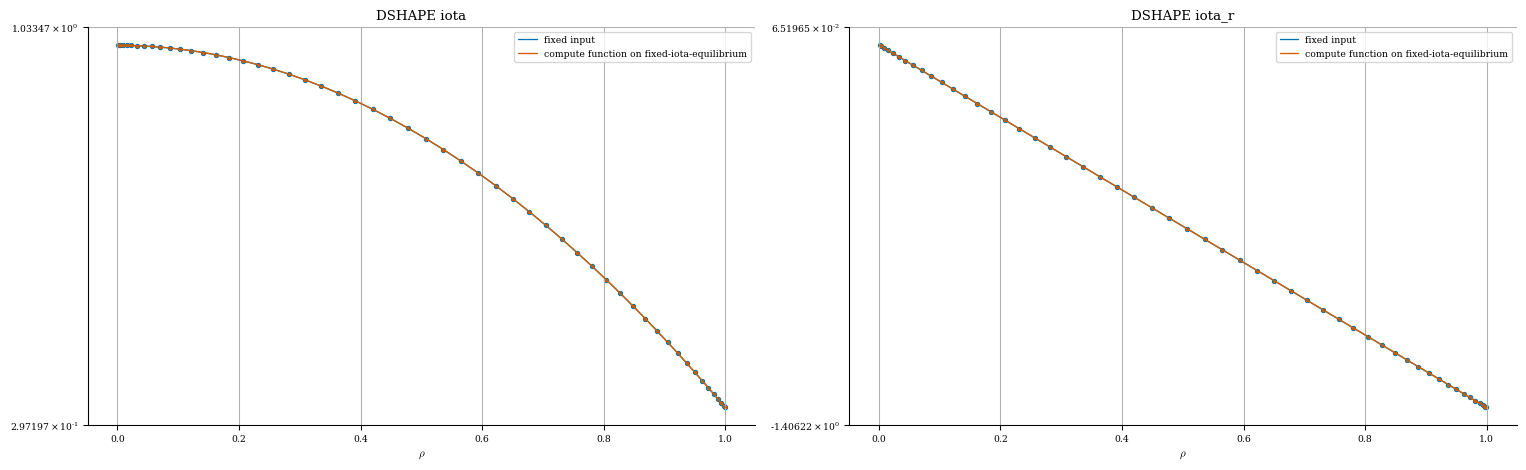

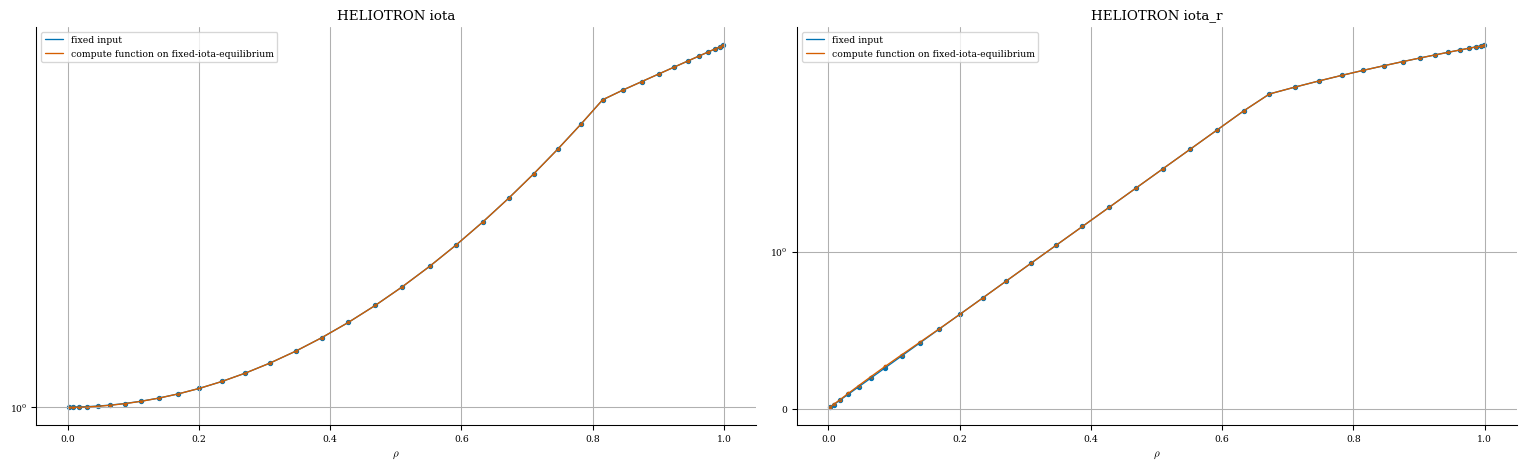

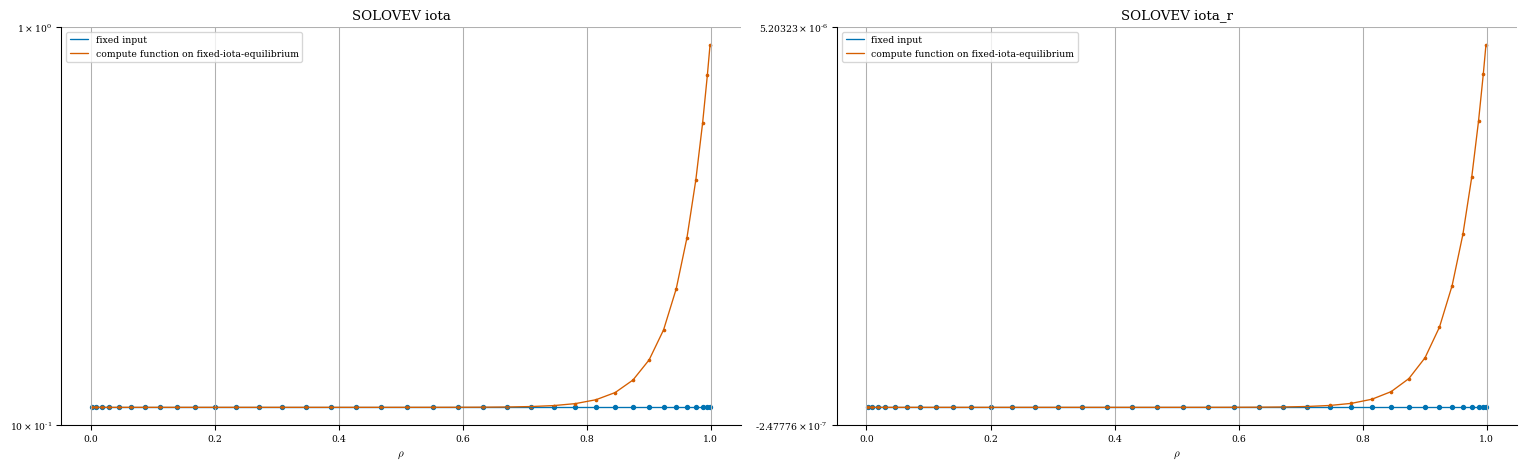

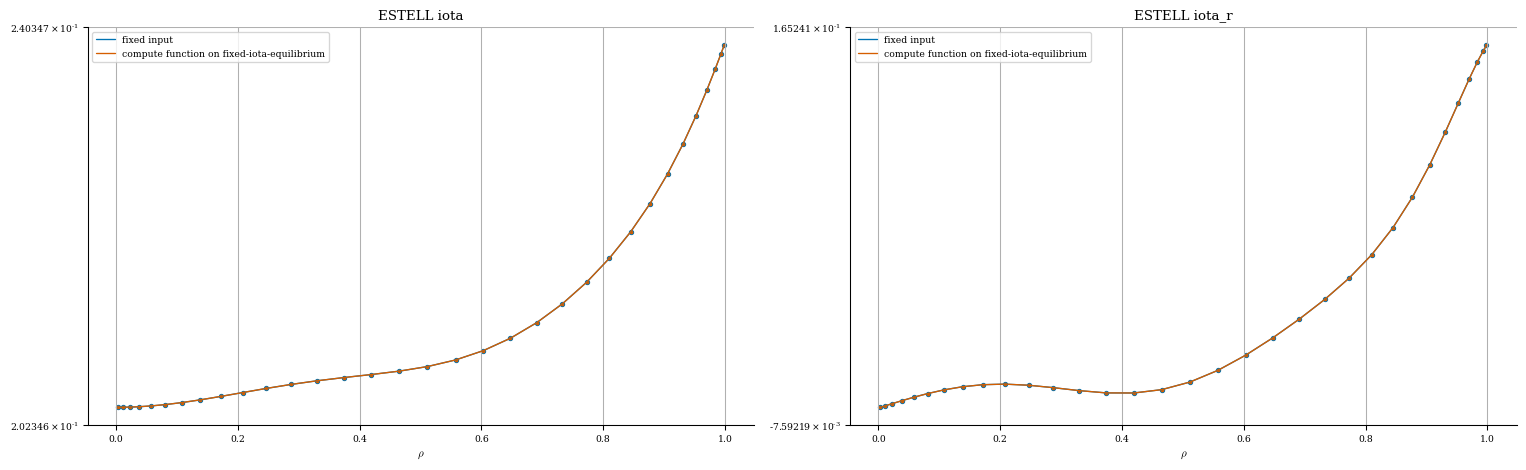

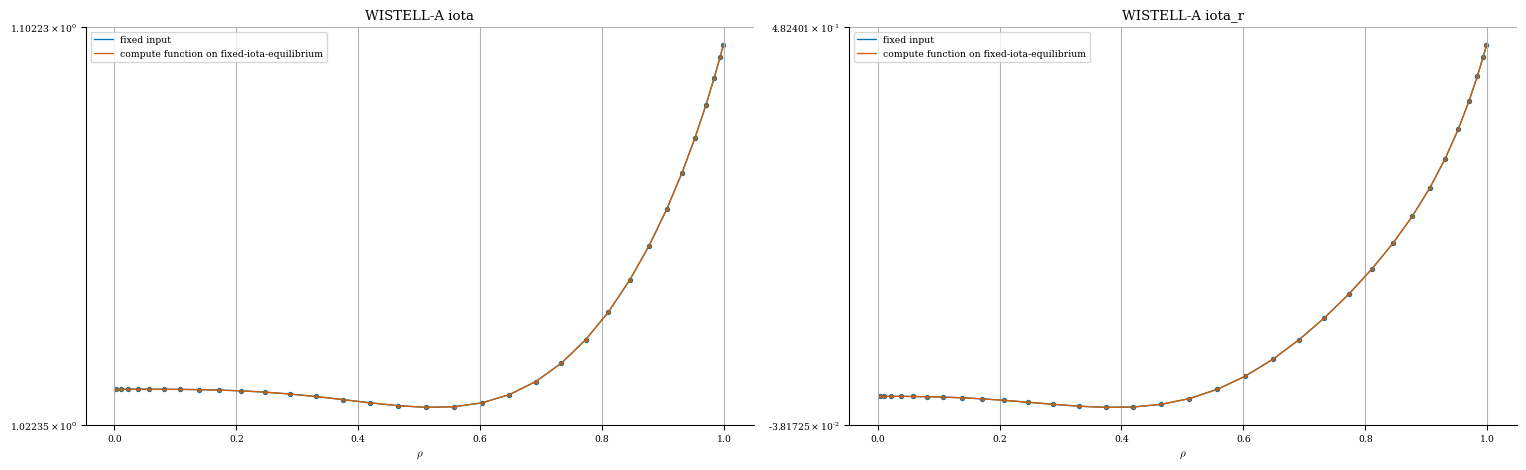

In [24]:
compare_iota_bootstrap("DSHAPE", dshape_fit)
compare_iota_bootstrap("HELIOTRON", heliotron_fit)
compare_iota_bootstrap("SOLOVEV", solovev_fit)
compare_iota_bootstrap("ESTELL", estell_fit)
compare_iota_bootstrap("WISTELL-A", wistell_fit)

## Compare iotas on equilibrium solved using fixed iota vs fixed current

In [9]:
# def compare_iota_fix_current_solve(name: str):
#     eq_1 = get_desc_eq(name)
#     eq_2 = get_desc_eq(name + "_quad", fix_current=True)
#     plot_comparison([eq_1, eq_2])
#
#     grid = get_grid(eq_2)
#     m = grid.unique_rho_idx
#     data_1 = eq_1.compute("iota", grid=grid)
#     data_2 = eq_2.compute("iota", grid=grid)
#
#     plot_overlay(
#         x=grid.nodes[m, 0],
#         y1=(data_1["iota"][m]), # data_1["iota_r"][m], data_1["iota_rr"][m]),
#         label_1="fixed iota solve",
#         y2=(data_2["iota"][m]), # data_2["iota_r"][m], data_2["iota_rr"][m]),
#         label_2="fixed current solve",
#         titles=tuple(name + " " + s for s in ("iota",)), # "iota_r", "iota_rr")),
#     )
#
#
# # compare_iota_fix_current_solve("DSHAPE")
# compare_iota_fix_current_solve("HELIOTRON")
# # compare_iota_fix_current_solve("SOLOVEV")
# # compare_iota_fix_current_solve("ESTELL")
# # compare_iota_fix_current_solve("WISTELL-A")

In [ ]:
# # eq_1 = get_desc_eq("HELIOTRON")
# from desc.plotting import plot_surfaces
# eq_2 = get_desc_eq("HELIOTRON_quad", fix_current=True)
# plot_surfaces(eq_2)
# plot_comparison(get_desc_eq("HELIOTRON"), eq_2)